In [1]:
import numpy as np
import matplotlib.pyplot as plt

import h5py

with h5py.File("digits.h5") as f:
    images = f["images"].value
    labels = f["labels"].value

print(images.shape)
print(labels.shape)

(120000, 9, 9)
(120000,)


# 1 Naive Bayes

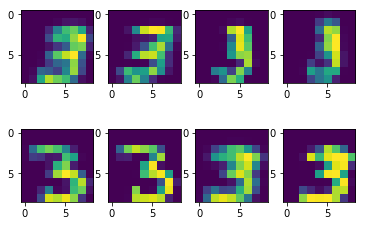

In [2]:
def plot8(images):
    images = images.reshape((-1,9,9))
    f, axes = plt.subplots(2,4)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
    plt.show()
    
    
digit = 3

images_single = images[labels == digit]
labels_single = labels[labels == digit]

plot8(images_single)

images_single.shape = -1, 81
images.shape = -1, 81

In [3]:
def fit_naive_bayes(features, labels, bincount=0):
    if bincount == 0:
        def gen_bin_widths():
            for l in np.unique(labels):
                x = features[labels==l]
                pct = np.percentile(x, (25, 75), axis=0)
                yield 2*np.subtract(pct[1], pct[0])
                
        widths = 2*np.stack(
            gen_bin_widths()
        )/np.cbrt(np.unique(labels).shape[0])
                
        def gen_bincounts():
            for l in np.unique(labels):
                x = features[labels==l]
                yield np.subtract(x.max(axis=0), x.min(axis=0))

        
        
        bincount = np.round(np.mean(
            np.ceil(
                np.stack(
                    gen_bincounts()
                )/widths
            )
        )).astype(int)        
    else:
        widths = np.zeros((np.unique(labels).shape[0], features.shape[1]))
        
    def gen_binning():
        for i,l in enumerate(np.unique(labels)):
            x = features[labels==l]
            yield np.stack(
                (x.min(axis=0),
                 np.maximum((x.max(axis=0)-x.min(axis=0)+0.001)/bincount, widths[i])),
                axis=0
            ).T
    
    binning = np.stack(
        gen_binning()
    )
    
    binning[binning[:,:,1]==0,1] = 1
        
    histograms = np.zeros(
        (np.unique(labels).shape[0], features.shape[1], bincount)
    )
    for i,l in enumerate(np.unique(labels)):
        x = features[labels==l]
        bins = np.floor(
            (x - binning[i,:,0])/binning[i,:,1]
        ).astype(int)
        for j in range(x.shape[0]):
            for k,l in enumerate(bins[j]):
                histograms[i, k, l] += 1
        histograms[i] /= x.shape[0]
        
    return histograms, binning

fit_naive_bayes(images_single, labels_single, bincount=8)[0].shape

(1, 81, 8)

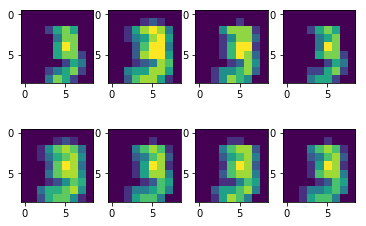

In [4]:
import itertools

def sample_naive_bayes(histograms, binning):
    cum_histogram = np.cumsum(histograms, axis=-1)
    
    t = np.random.random_sample()
    
    bins = np.argmax(cum_histogram >= t, axis=-1).flatten()
    
    image = binning[:,:,0] + bins*binning[:,:,1]
    image.shape = 9, 9
    
    return image
    
histograms, binning = fit_naive_bayes(images_single, labels_single, bincount=10)

samples = np.array([sample_naive_bayes(histograms, binning) for i in range(8)])

plot8(samples)

# 2 Data Generation and Classification with Density Trees
## 2.1 Train Tree by Error Minimization

In [5]:
class Node:
    def __init__(self):
        self.left  = None
        self.right = None
        self.data  = None
        self.feature_index = None
        self.threshold = None
        self.score = None
        self.bbox = None
        
    def __lt__(self, other):
        return self.score < other.score

In [6]:
import heapq

def score_min_error(node, N):
    features = node.data
    V_before = np.prod(np.abs(node.bbox[:,1]-node.bbox[:,0]), dtype=np.float128)
    before_split = (features.shape[0]/N)**2/V_before
    best_feature = None
    best_threshold = None
    best_score = np.inf
    for i in range(features.shape[-1]):
        thresholds = np.linspace(features[:,i].min(),
                                   features[:,i].max(),
                                   11, False)[1:]

        for t in thresholds:
            N_left = features[features[:,i] <= t].shape[0]
            bbox_left = node.bbox
            bbox_left[i][1] = t
            V_left = np.prod(np.abs(bbox_left[:,1]-bbox_left[:,0]))
            V_right = V_before - V_left
            score = (-before_split + (N_left/N)**2/V_left 
                   + (1 - N_left/N)**2/V_right)
            if score <= best_score:
                best_feature = i
                best_threshold = t
                best_score = score
#     print(features[:,best_feature].min(),features[:,best_feature].max(),
#          best_threshold)
    return best_score, best_feature, best_threshold
    

def fit_density_tree1(features, bincount):
    """Fit a density tree by error minimization
    
    Args:
        features (ndarray): The data to estimate
        bincount (int): The number of bins to create
    
    Returns:
        Node: Root of the created density tree
    """
    N = features.shape[0]
    
    root = Node()
    root.data = features
    root.bbox = np.stack((features.min(axis=0), features.max(axis=0))).T
    root.score, root.feature_index, root.threshold = score_min_error(root, N)
        
    stack = [root]
    
    count = 1
    while stack:
        node = heapq.heappop(stack)
        
        if node.data.shape[0] < 2 or node.threshold is None:
            continue
            
#         print(node.data.shape)
#         print(node.threshold)
        
        node.left = Node()
        node.left.data = node.data[node.data[:,node.feature_index] <= node.threshold]
        node.left.bbox = node.bbox
        node.left.bbox[node.feature_index][1] = node.threshold

        node.left.score, node.left.feature_index, node.left.threshold = score_min_error(node.left, N)
        
        node.right = Node()
        node.right.data = node.data[node.data[:,node.feature_index] > node.threshold]
        node.right.bbox = node.bbox
        node.right.bbox[node.feature_index][0] = node.threshold

        # If the array contains only elements of the same value,
        # all elementes are in node.left
        if node.right.data.shape[0] < 1:
            node.bbox = node.left.bbox
            continue
            
        node.right.score, node.right.feature_index, node.right.threshold = score_min_error(node.right, N)
       
        count += 1
        heapq.heappush(stack, node.left)
        heapq.heappush(stack, node.right)
        
        if count >= bincount:
            break
    
    return root

In [7]:
def sample_density_tree(density_tree):
    N = density_tree.data.shape[0]
    
    t = np.random.random_sample()
    
    node = density_tree
    while True:
        P = node.data.shape[0]/N
        if t <= P:
            if node.left is None:
                break
            node = node.left
        else:
            if node.right is None:
                break
            t = t - P
            node = node.right
            
    image = np.random.uniform(node.bbox[:,0], node.bbox[:,1])
    image.shape = 9, 9
    return image

/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in longdouble_scalars
  
/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longdouble_scalars
/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in longdouble_scalars


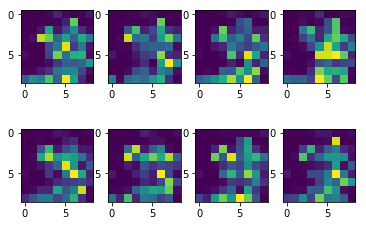

In [8]:
tree = fit_density_tree1(images_single/255, np.floor(15*np.cbrt(images_single.shape[0])).astype(int))
samples = np.array([sample_density_tree(tree) for i in range(8)])
plot8(samples)

## 2.2 Train Tree by Maximizing Non-Uniformity

In [9]:
def score_max_nonuni(node, N):
    features = node.data
    V_before = np.prod(np.abs(node.bbox[:,1]-node.bbox[:,0]), dtype=np.float128)
    N_before = features.shape[0]
    best_feature = None
    best_threshold = None
    best_score = np.inf
    for i in range(features.shape[-1]):
        thresholds = np.linspace(features[:,i].min(),
                                   features[:,i].max(),
                                   11, False)[1:]

        for t in thresholds:
            N_left = features[features[:,i] <= t].shape[0]
            bbox_left = node.bbox
            bbox_left[i][1] = t
            V_left = np.prod(np.abs(bbox_left[:,1]-bbox_left[:,0]))
            score = (N_left * V_before - N_before * V_left)**2/(V_left*(V_before - V_left))
            if score <= best_score:
                best_feature = i
                best_threshold = t
                best_score = score
#     print(features[:,best_feature].min(),features[:,best_feature].max(),
#          best_threshold)
    return best_score, best_feature, best_threshold
    

def fit_density_tree2(features, bincount):
    """Fit a density tree by error minimization
    
    Args:
        features (ndarray): The data to estimate
        bincount (int): The number of bins to create
    
    Returns:
        Node: Root of the created density tree
    """
    N = features.shape[0]
    
    root = Node()
    root.data = features
    root.bbox = np.stack((features.min(axis=0), features.max(axis=0))).T
    root.score, root.feature_index, root.threshold = score_max_nonuni(root, N)
        
    stack = [root]
    
    count = 1
    while stack:
        node = heapq.heappop(stack)
        
        if node.data.shape[0] < 2 or node.threshold is None:
            continue
            
#         print(node.data.shape)
#         print(node.threshold)
        
        node.left = Node()
        node.left.data = node.data[node.data[:,node.feature_index] <= node.threshold]
        node.left.bbox = node.bbox
        node.left.bbox[node.feature_index][1] = node.threshold

        node.left.score, node.left.feature_index, node.left.threshold = score_max_nonuni(node.left, N)
        
        node.right = Node()
        node.right.data = node.data[node.data[:,node.feature_index] > node.threshold]
        node.right.bbox = node.bbox
        node.right.bbox[node.feature_index][0] = node.threshold

        # If the array contains only elements of the same value,
        # all elementes are in node.left
        if node.right.data.shape[0] < 1:
            node.bbox = node.left.bbox
            continue
            
        node.right.score, node.right.feature_index, node.right.threshold = score_max_nonuni(node.right, N)
       
        count += 1
        heapq.heappush(stack, node.left)
        heapq.heappush(stack, node.right)
        
        if count >= bincount:
            break
    
    return root

/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in longdouble_scalars
/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longdouble_scalars


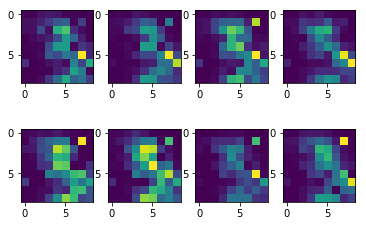

In [10]:
tree = fit_density_tree2(images_single/255, np.floor(25*np.cbrt(images_single.shape[0])).astype(int))
samples = np.array([sample_density_tree(tree) for i in range(8)])
plot8(samples)

## 2.3 Tree-Based Classification

In [11]:
classes = np.array([3, 9])
def predict_density_trees(test_features, tree_for_3, tree_for_9):
    probs = []
    for f in test_features:
        node3 = tree_for_3
        while node3.left is not None:
            if f[node3.feature_index] <= node3.threshold:
                node3 = node3.left
            else:
                node3 = node3.right
                
        node9 = tree_for_9
        while node9.left is not None:
            if f[node9.feature_index] <= node9.threshold:
                node9 = node9.left
            else:
                node9 = node9.right
                
        probs.append((
            node3.data.shape[0]/tree_for_3.data.shape[0],
            node9.data.shape[0]/tree_for_9.data.shape[0]
        ))
    
    probs = np.array(probs)
    
    return classes[np.argmax(probs, axis=1).astype(int)]

In [12]:
images_3 = images[labels == 3]
images_9 = images[labels == 9]

tree3 = fit_density_tree2(images_3/255, np.floor(25*np.cbrt(images_3.shape[0])).astype(int))
tree9 = fit_density_tree2(images_9/255, np.floor(25*np.cbrt(images_9.shape[0])).astype(int))

with h5py.File("digits_test.h5") as f:
    test_images = f["images"].value
    test_labels = f["labels"].value

test_images.shape = -1, 81
    
test_images39 = test_images[np.logical_or(test_labels==3, test_labels==9)]
test_labels39 = test_labels[np.logical_or(test_labels==3, test_labels==9)]

/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in longdouble_scalars
/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longdouble_scalars


In [13]:
import pandas as pd
pd.crosstab(test_labels39, predict_density_trees(test_images39, tree3, tree9),
           rownames=['Actual'], colnames=['Predicted'])

Predicted     3     9
Actual               
3          3704  6396
9          3634  6456

In this case, the density tree performs worse than the naive bayes classifier. This is at least amplified if not caused by a bug I cannot find.

# 3 Data Generation with a Multi-dimensional Gaussian

In [14]:
def fit_qda(training_features):
    mean = training_features.mean(axis=0)
    covmat = np.cov(training_features.T)
    
    return mean, covmat

def sample_qda(mean, covmat):
    return np.random.multivariate_normal(mean, covmat)

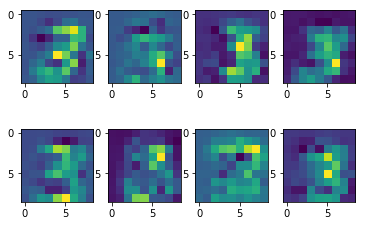

In [15]:
mu, sigma = fit_qda(images_single)
samples = np.array([sample_qda(mu, sigma) for i in range(8)])
plot8(samples)